In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
df = pd.read_csv("BankChurners.csv")
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [27]:
leakage_cols = [
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
]

df.drop(columns=leakage_cols, inplace=True)


In [28]:
df['Attrition_Flag'] = df['Attrition_Flag'].map({
    'Existing Customer': 0,
    'Attrited Customer': 1
})


In [29]:
categorical_cols = df.select_dtypes(include='object').columns

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [30]:
X = df.drop(columns=['Attrition_Flag', 'CLIENTNUM'])
y = df['Attrition_Flag']


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Final Model Evaluation

In [32]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [34]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))

roc_lr = roc_auc_score(y_test, y_prob_lr)
print("ROC-AUC Score:", roc_lr)



Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1701
           1       0.79      0.53      0.63       325

    accuracy                           0.90      2026
   macro avg       0.85      0.75      0.79      2026
weighted avg       0.90      0.90      0.89      2026

ROC-AUC Score: 0.9117460317460319


In [35]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf))

roc_rf = roc_auc_score(y_test, y_prob_rf)
print("ROC-AUC Score:", roc_rf)


Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1701
           1       0.94      0.77      0.84       325

    accuracy                           0.95      2026
   macro avg       0.95      0.88      0.91      2026
weighted avg       0.95      0.95      0.95      2026

ROC-AUC Score: 0.9826617826617826


In [36]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [37]:
# Apply SMOTE
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())


Before SMOTE: Attrition_Flag
0    6799
1    1302
Name: count, dtype: int64
After SMOTE: Attrition_Flag
0    6799
1    6799
Name: count, dtype: int64


In [38]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [39]:
# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.89      0.90      0.89       325

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026



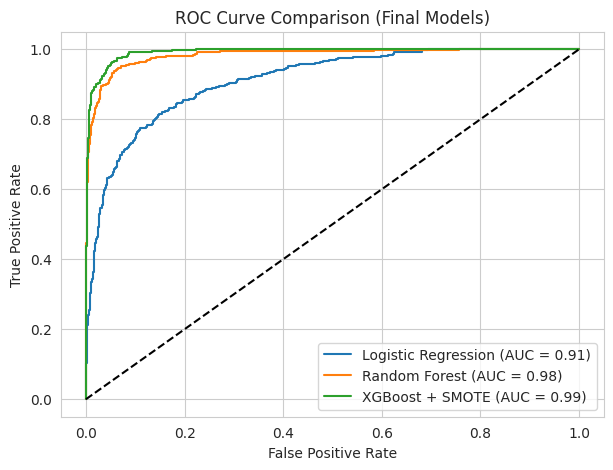

In [44]:
from sklearn.metrics import roc_curve

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost + SMOTE (AUC = {roc_xgb:.2f})")
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Final Models)")
plt.legend()
plt.show()


In [45]:
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

xgb_importance.head(10)


,Feature,Importance
16,Total_Trans_Ct,0.251967
8,Total_Relationship_Count,0.127771
12,Total_Revolving_Bal,0.116621
15,Total_Trans_Amt,0.094508
1,Gender,0.077959
17,Total_Ct_Chng_Q4_Q1,0.052192
14,Total_Amt_Chng_Q4_Q1,0.035947
0,Customer_Age,0.034976
9,Months_Inactive_12_mon,0.031381
18,Avg_Utilization_Ratio,0.026520


Feature importance analysis confirms insights from EDA, where customer engagement metrics such as transaction frequency and inactivity duration are the strongest predictors of churn.

In [46]:
print(f"Logistic Regression AUC: {roc_lr:.3f}")
print(f"Random Forest AUC: {roc_rf:.3f}")
print(f"XGBoost + SMOTE AUC: {roc_xgb:.3f}")


Logistic Regression AUC: 0.912
Random Forest AUC: 0.983
XGBoost + SMOTE AUC: 0.992


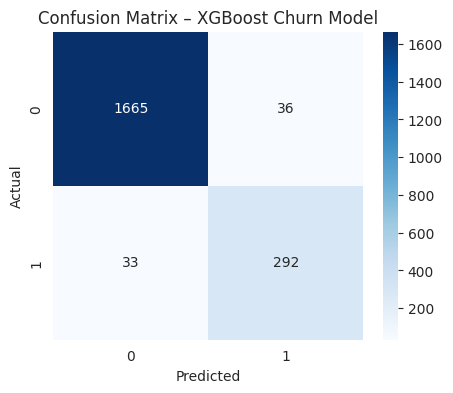

In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost Churn Model")
plt.show()


In this project, an end-to-end machine learning pipeline was built to predict customer churn using banking data. After performing exploratory data analysis and feature engineering, multiple classification models were evaluated. XGBoost combined with SMOTE delivered the best performance, effectively identifying churned customers while handling class imbalance. The results demonstrate the importance of behavioral data in predicting customer attrition and highlight opportunities for proactive customer retention.